# **Team Members:**


1.   Eman Allam        201900903
2.   Hagar alaaeldien  202000692
3.   Mohamed Khalid    201901493



# **JPEG Algorithm Specifications:**

1.   Low Quantization:

  *   Image Quality (PCNR): 49.12614517702116
  *   Compression ratio: 54.9437559580553%
  *   Qualitatively: The low-compressed image seems similar to the original with a slight drop in quality


2.   High Quantization:
  *   Image Quality (PCNR): 31.21872338287442
  *   Compression ratio: 35.59580552907531%
  *   Qualitatively: The high-compressed image seems to maintain the overall important data with a higher drop in quality



# **Results**
*   Size after high compression: 9335
*   Size after low compression: 14409
*   Size of original image: 26225




*Given these results and specifications, we choose low quantization as it keeps a decent quality with approximately half the size.*


In [262]:
import heapq
from collections import Counter
import numpy as np
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step #1**
Read and divide the image into blocks of 8x8 pixels

In [263]:
def divide_image_into_blocks(image_path, block_size=8):
    try:
        img = Image.open(image_path)
        img_array = np.array(img)

        blocks = [] # List to store all the blocks
        for x in range(0, img_array.shape[0], block_size):
            for y in range(0, img_array.shape[1], block_size):
                block = img_array[x:x+block_size, y:y+block_size]

                # Check if the block is smaller than 8x8 and pad it if necessary
                if block.shape[0] < block_size or block.shape[1] < block_size:
                    # Pad the block with zeros to make it 8x8
                    block = np.pad(block,
                                   ((0, max(0, block_size - block.shape[0])),
                                    (0, max(0, block_size - block.shape[1]))),
                                   mode='constant', constant_values=0)
                blocks.append(block)
        return blocks
    except IOError:
        print("Error in loading the image. Please check the file path.")
        return []

# **Step #2**
Perform DCT on each block

In [264]:
def dct_2d(block):
    N = block.shape[0]
    dct_entry = np.zeros((N, N))

    for u in range(N):
        for v in range(N):

            if u == 0 and v == 0:
                scale_factor = 64

            elif u == 0 or v == 0:
                scale_factor = 32

            else:
                scale_factor = 16

            sum = 0
            for x in range(N):
                for y in range(N):
                    sum += block[x,y]*np.cos((2*x+1)*u*np.pi/(2*N))*np.cos((2*y+1)*v*np.pi/(2*N)) #DCT Basis Equation
            sum /= scale_factor
            dct_entry[u, v] = sum
    return dct_entry

# **Step #3**
**Perform the quantization step per 8x8 block using at least two quantization tables.**


in this step, we divided each element of the 8x8 block by its correspondent in the quantization table, this step reduces the range of the values, consequently reducing the bit precision.

we're going to test two quantization tables one that results in lower compression (a) than the other (b), meaning the compressed picture retains more data and takes higher space.

Used Quantization tables:

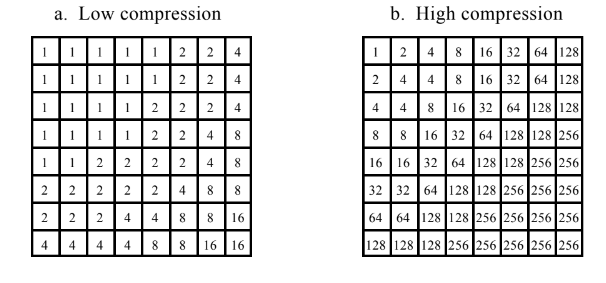

In [265]:
# Low compression quantization table
Low_QT = np.array([ [1,1,1,1,1,2,2,4],
                    [1,1,1,1,1,2,2,4],
                    [1,1,1,1,2,2,2,4],
                    [1,1,1,1,2,2,4,8],
                    [1,1,2,2,2,2,4,8],
                    [2,2,2,2,2,4,8,8],
                    [2,2,2,4,4,8,8,16],
                    [4,4,4,4,8,8,16,16]
                    ])

# High compression quantization table
High_QT = np.array([  [1,2,4,8,16,32,64,128],
                      [2,4,4,8,16,32,64,128],
                      [4,4,8,16,32,64,128,128],
                      [8,8,16,32,64,128,128,256],
                      [16,16,32,64,128,128,256,256],
                      [32,32,64,128,128,256,256,256],
                      [64,64,128,128,256,256,256,256],
                      [128,128,128,256,256,256,256,256]
                    ])

In [266]:
def Quantize(DCT, QType):
  # function that thakes DCT 8x8 block (DCT) and the quantization type (QType) then returns the quantized DCT

  if QType == 'L': # If the specified quantizattion type is low
    return np.round(DCT/Low_QT) # divide the DCT by the Low Quantization table

  elif QType == 'H': # If the specified quantizattion type is low
    return np.round(DCT/High_QT) # divide the DCT by the High Quantization table

# **Step #4**
**Transform each block from 2-D into 1-D vector using the following pattern (Zigzag).**






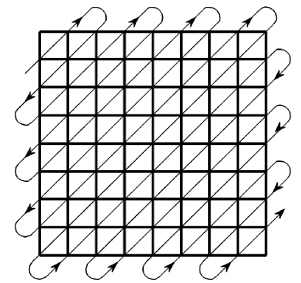

As seen in the figure:
  

1.   indices in each consecuitve scan have the same sum, e.g. [2,0], [1,1], [0,2]

Then this process can be split to two parts:


1.   Above the diagonal, going from the top-right to the bottom-left:

  *   If the sum is even, then the indices start from [sum,0] following [sum - order in scan, order in scan] up until it reaches [0,sum]
  *   If the sum is odd, then the indices start from [0,sum] following [order in scan, sum - order in scan] up until it reaches [sum,0]


2.   Below the diagonal, going from the top-right to the bottom-left:

  *   if The sum is even, then the indices start from [7,sum-7] following [sum -7+ order in scan, 7-order in scan] up until it reaches [sum-7,7]
  *   If the sum is odd, then the indices start from [sum-7,7] following [7-order in scan, sum -7+ order in scan] up until it reaches [7,sum-7]

In [267]:
def Zigzag_Scan(Vector_2D):
  # a function that takes a 2D vector and returns it as 1D zigzag scanned vector
  Vector_1D = np.empty(0)
  Count = 0
  for Sum in range(15):
    if Sum > 7:
      Bounds = 14 - Sum
    else:
      Bounds = Sum
    for j in range(Bounds+1):
      if Sum <= 7:
        if Sum % 2 == 0:
          Vector_1D = np.append(Vector_1D,Vector_2D[Sum-j][j])
        else:
          Vector_1D = np.append(Vector_1D,Vector_2D[j][Sum-j])
      else:
        if Sum % 2 == 0:
          Vector_1D = np.append(Vector_1D,Vector_2D[7-j][Sum-7+j])
        else:
          Vector_1D = np.append(Vector_1D,Vector_2D[Sum-7+j][7-j])
  return Vector_1D

# **Step #5**
Use run-length encoding to compress the stream of zeros that may results due to the quantization.

In [268]:
def Run_Length_Encoder(Vector):
  Count = 0
  Encoded_Vector = []
  for i in range(int(len(Vector))): # loop on the vector one bit at a time
    if Vector[i] == 0:
      # if the bit (i) equals 0 then increase the counter
      Count += 1
    elif Count != 0 :
      ''' if the bit (i) doesn't equal 0 and the counter equals 0 add it to the encoded vector this means that
      before the current bit, existed a stream of zeroes so add a zero and the number of zeroes in the stream to the encoded vecteor'''
      Encoded_Vector = np.append(Encoded_Vector, [0,Count,Vector[i]])
      Count = 0 #reset the count to zero
    else:
      # if the bit (i) doesn't equal 0 and the counter equals 0 add it to the encoded vector
      Encoded_Vector = np.append(Encoded_Vector, Vector[i])
    if i == len(Vector) - 1 and Count!=0:
      Encoded_Vector = np.append(Encoded_Vector, [0,Count])
  return Encoded_Vector #return the run-length encoded vector

# **Step #6**
Huffman Encoder

In [269]:
class Node:
    def __init__(self, symbol, prob):
        self.symbol = symbol
        self.prob = prob
        self.left = None
        self.right = None
        self.code = '' # tree direction (0/1)
    def __lt__(self, other):
        return self.prob < other.prob

def HuffmanEncoder(stream):
  #Find probability of each symbol
  prob = Counter(stream)

  #Create MIN heap
  heap = []
  for symbol, prob in prob.items():
    heap.append(Node(symbol,prob))
  heapq.heapify(heap)

  #Add each two smallest nodes and push it into the heap
  while len(heap)>1:
    left_node = heapq.heappop(heap)
    right_node = heapq.heappop(heap)
    #code each child
    left_node.code += "0"
    right_node.code += "1"
    #create new node with its children
    new_node = Node(None,left_node.prob + right_node.prob)
    new_node.left = left_node
    new_node.right = right_node

    heapq.heappush(heap, new_node)

  coded_symbols = {}
  coding(heap[0],coded_symbols) #returns the code of each symbol
  #coding the stream of info
  coded_stream = []
  for i in range(len(stream)):
    for j in coded_symbols.keys():
      if stream[i] == j:
        coded_stream +=(coded_symbols.get(j))
        break
  return coded_symbols, coded_stream

def coding(node,coded_symbols):
  #preorder traversal
  if node is None:
      return

  # Deal with the node
  if node.left is not None:
    node.left.code=node.code + node.left.code
    if node.left.symbol is not None:
      coded_symbols[node.left.symbol] = node.left.code
    # Recur on left subtree
    coding(node.left,coded_symbols)
  if node.right is not None:
    node.right.code=node.code + node.right.code
    if node.right.symbol is not None:
      coded_symbols[node.right.symbol] = node.right.code
    # Recur on right subtree
    coding(node.right,coded_symbols)
  return coded_symbols

# **Step #7**
Huffman Decoder

In [270]:
def HuffmanDecoder(coded_dict,coded_stream):

    reverse = {}
    for k,v in coded_dict.items():
        reverse[v] = k

    sortedCodes  =sorted(reverse.keys(),key=len,reverse=True) #Sorting them accordng to the length of each code (Longer codes are checked first)
    output =[]
    current_code= ""
    codedstring ="".join(coded_stream)
    LengthString = len(codedstring)

    while LengthString != 0: #Iterate the encoded sring to decode it
        for code in sortedCodes:
            if codedstring.startswith(code):
                symbol =reverse[code]
                output.append(symbol)
                codedstring =codedstring[len(code):]  #If the code is founded in the string, remove it to decode the rest
                LengthString = len(codedstring)
                break
    return output

# **Step #8**
Run-length Decoding

In [271]:
def Run_Length_Decoder(Vector):
  Count = 0
  Decoded_Vector = []
  i=0
  while i in range(len(Vector)):
    if Vector[i] == 0 or Vector[i] == -0:
      for j in range(int(Vector[i+1])): #check for the number of zeroes and add to the decoded vector
        Decoded_Vector = np.append(Decoded_Vector, 0)
      i+=2 #add 2 to i to skip the 0 count bit
    else:
      Decoded_Vector = np.append(Decoded_Vector, Vector[i]) #if the current bit is non-zero add to the decoded vector
      i+=1
  return Decoded_Vector #return the run-length decoded vector

# **Step #9**
Transform the 1-D vector into groups of 8x8 matrices (Reverse Zigzag).

In [272]:
def Reverse_Zigzag_Scan(Vector_1D):
  # a function that takes a 1D vector and returns it as 2D reverse zigzag scanned vector
    Matrices_List = []
    Vector_2D = np.zeros((8, 8))
    index = 0
    for i in range (int(len(Vector_1D)/64)):
      for Sum in range(15):
        if Sum > 7:
          Bounds = 14 - Sum
        else:
          Bounds = Sum
        for j in range(Bounds+1):
          if Sum <= 7:
            if Sum % 2 == 0:
              Vector_2D[Sum-j][j] += Vector_1D[index]
            else:
              Vector_2D[j][Sum-j] += Vector_1D[index]
          else:
            if Sum % 2 == 0:
              Vector_2D[7-j][Sum-7+j] += Vector_1D[index]
            else:
              Vector_2D[Sum-7+j][7-j] += Vector_1D[index]
          index += 1
      Matrices_List.append(Vector_2D)
      index = 0
      Vector_2D = np.zeros((8, 8))
    return Matrices_List

# **Step #10**
Multiply each group by the quantization tables.

In [273]:
def Dequantize(Matrix, DQType):
    # function that thakes DCT 8x8 block (DCT) and the dequantization type (DQType) then returns the dequantized DCT

  if DQType == 'L': # If the specified dequantization type is low
    return Matrix * Low_QT # multiply the DCT by the Low Quantization table

  elif DQType == 'H': # If the specified dequantization type is high
    return Matrix * High_QT # multiply the DCT by the high Quantization table

# **Step #11**
IDCT

In [274]:
def idct_2d(dct_block):
    N = dct_block.shape[0]
    idct_entry = np.zeros((N, N))
    for x in range(N):
        for y in range(N):
            sum = 0
            for u in range(N):
                for v in range(N):
                    sum +=dct_block[u, v]*np.cos((2*x+1)*u*np.pi/(2*N))*np.cos((2*y+1)*v*np.pi/(2*N))#IDCT Basis Equation
            #print(sum)
            idct_entry[x,y] =sum
    return idct_entry

# **Step #12**
Combine the 8x8 pixel groups into a single image and save it back to a file

In [275]:
def combine_blocks_into_image(blocks,image_shape,block_size=8):
    image_height,image_width =image_shape
    blocks_per_column=int(np.ceil(image_height/block_size))
    blocks_per_row=int(np.ceil(image_width/block_size))

    combined_image = np.zeros((blocks_per_column*block_size,blocks_per_row*block_size),dtype=blocks[0].dtype)

    for block_index, block in enumerate(blocks):
        row =block_index//blocks_per_row
        col =block_index%blocks_per_row
        combined_image[row*block_size:(row+1)*block_size,col*block_size:(col+1)*block_size] =block

    combined_image = combined_image[:image_height, :image_width]
    return combined_image

# Size Calculation

In [276]:
def get_size_after_compression(encoded_data_list):
    all_bits_combined = ''

    # Iterate over each entry and concatenate the bits
    for _, bits_list in encoded_data_list:
        all_bits_combined += ''.join(bits_list)

    # Calculate the size in bits
    total_size_in_bits = len(all_bits_combined)

    return total_size_in_bits

# **Bonus Part**

In [277]:
def assignRanges(prob_symbols):
    ranges = {}
    count_forRanges = 0.0
    for symbol, prob in prob_symbols.items():
        ranges[symbol] = (count_forRanges, count_forRanges + prob)
        count_forRanges += prob
    return ranges

def symbol_FAE(ranges, s, low, high):
    symbol_range = ranges[s]
    new_low = low + symbol_range[0] * (high - low)
    new_high = low + symbol_range[1] * (high - low)
    return new_low, new_high

def finiteArithmeticEncoder(stream, precision):
    low = 0.0
    high = 1.0
    freq_symbols = Counter(stream)
    prob_symbols = {k: v / len(stream) for k, v in freq_symbols.items()}
    s_ranges = assignRanges(prob_symbols)

    for s in stream:
        low, high = symbol_FAE(s_ranges, s, low, high)

    #scaling
    scale = 10 ** precision
    scaled_low = int(low * scale)
    scaled_high = int(high * scale)
    return scaled_low

def finiteArithmeticDecoder(encoded_value, stream_length, precision, prob_symbols):
    low = 0.0
    high = 1.0
    s_ranges = assignRanges(prob_symbols)
    scale = 10 ** precision
    current_value = encoded_value / scale

    decoded_stream = []
    for _ in range(stream_length):
        range_width = high - low
        for s, (s_low, s_high) in s_ranges.items():
            new_low = low + s_low * range_width
            new_high = low + s_high * range_width

            if new_low <= current_value < new_high:
                decoded_stream.append(s)
                low, high = new_low, new_high
                break

    return decoded_stream

# **Code Flow**

In [278]:
image_path = '/content/drive/MyDrive/UNI/B2DBy.jpg'
import cv2
image = cv2.imread('/content/drive/MyDrive/UNI/B2DBy.jpg')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_gray.shape


save_path = '/content/drive/MyDrive/UNI/grayscale_B2DBy.jpg'

# Save the grayscale image to the specified path
cv2.imwrite(save_path, img_gray)

True

In [279]:
blocks = divide_image_into_blocks(save_path)

In [280]:
dctBlocks = [] #Array of the DCT of the img blocks
for block in blocks:
  dctBlocks.append(dct_2d(block)) # DCT each block and add to the array
dctBlocks

[array([[ 9.10000000e+01, -1.02008259e+00,  9.11070785e-01,
          2.21007466e-02,  4.41941738e-02, -1.82570981e-02,
          5.30555676e-03, -3.97303877e-02],
        [-2.11404185e+00, -5.97131039e-02, -6.86083363e-02,
          5.04101853e-02,  6.59888259e-03,  3.12500000e-02,
          8.87129633e-02, -3.64125522e-03],
        [-1.69123781e-02,  7.80681347e-02,  1.50888348e-01,
         -7.65198182e-02,  1.05577900e-01, -2.02297301e-03,
          8.83883476e-02, -6.05887064e-02],
        [-2.47912944e-02, -3.12500000e-02,  3.57128952e-03,
          6.92281623e-02,  4.53679682e-02, -7.12907677e-02,
         -4.62059110e-02,  6.50747563e-02],
        [-4.41941738e-02, -2.81242570e-02, -2.39177145e-02,
         -1.59311118e-02, -1.25000000e-01,  8.00911077e-02,
         -5.77424708e-02, -1.87920277e-02],
        [ 5.02659991e-02, -2.57475626e-03, -1.79540849e-02,
         -1.59679115e-01,  6.78979626e-02,  2.32548533e-01,
          9.95935091e-02,  3.12500000e-02],
        [-4.0830

In [281]:
LowQuant = [] #array of low quantized blocks
HighQuant = [] #array of high quantized blocks
for dctBlock in dctBlocks:
  LowQuant.append(Quantize(dctBlock , "L")) # Quantize the DCT block using the low quantization table and add to the array
  HighQuant.append(Quantize(dctBlock , "H"))  # Quantize the DCT block using the high quantization table and add to the array

In [282]:
LQuant_1D = [] #array of 1_dimensional low quantized blocks
HQuant_1D = [] #array of 1_dimensional high quantized blocks
for LQuant in LowQuant:
  LQuant_1D.append(Zigzag_Scan(LQuant)) #zigzag scan the 2-D low quantized blocks and transform it to 1_D vector and add to the array
for HQuant in HighQuant:
  HQuant_1D.append(Zigzag_Scan(HQuant)) #zigzag scan the 2-D low quantized blocks and transform it to 1_D vector and add to the array

In [283]:
RLC_Low = [] #array of run-length encoded low quantized array
RLC_High = [] #array of run-length encoded high quantized array
for LQ in LQuant_1D:
  RLC_Low.append(Run_Length_Encoder(LQ)) #run length encode stream of low quantized vector and add to the array
for HQ in HQuant_1D:
  RLC_High.append(Run_Length_Encoder(HQ)) #run length encode stream of high quantized vector and add to the array

In [284]:
HuffEncoded_low = [] #array of huffman encoded low quantized array
HuffEncoded_high = [] #array of huffman encoded high quantized array
for RLC_l in RLC_Low:
  HuffEncoded_low.append(HuffmanEncoder(RLC_l)) #huffman encode stream of low quantized vector and add to the array
for RLC_h in RLC_High:
   HuffEncoded_high.append(HuffmanEncoder(RLC_h)) #huffman encode stream of high quantized vector and add to the array

In [285]:
HuffDecoded_low = [] #array of huffman decoded low quantized array
HuffDecoded_high = [] #array of huffman decoded high quantized array
for Huff_l in HuffEncoded_low:
  HuffDecoded_low.append(HuffmanDecoder(Huff_l[0],Huff_l[1])) #huffman decode stream of low quantized vector and add to the array
for Huff_h in HuffEncoded_high:
   HuffDecoded_high.append(HuffmanDecoder(Huff_h[0],Huff_h[1])) #huffman decode stream of high quantized vector and add to the array

In [286]:
RLDC_Low = [] #array of run-length decoded low quantized array
RLDC_High = [] #array of run-length decoded high quantized array
for HD_L in HuffDecoded_low:
  RLDC_Low.append(Run_Length_Decoder(HD_L)) #run-length decode stream of low quantized vector and add to the array
for HD_H in HuffDecoded_high:
  RLDC_High.append(Run_Length_Decoder(HD_H)) #run-length decode stream of high quantized vector and add to the array

In [287]:
LQuant_2D = [] #array of 2_dimensional low quantized blocks
HQuant_2D = [] #array of 2_dimensional high quantized blocks
for RLDC_L in RLDC_Low:
  LQuant_2D.append(Reverse_Zigzag_Scan(RLDC_L)) #reverse zigzag scan the 1-D low quantized blocks and transform it to 2_D vector and add to the array
for RLDC_H in RLDC_High:
  HQuant_2D.append(Reverse_Zigzag_Scan(RLDC_H)) #reverse zigzag scan the 1-D high quantized blocks and transform it to 2_D vector and add to the array

In [288]:
LowDequant = [] #array of low dequantized blocks
HighDequant = [] #array of high dequantized blocks
for LDQ in LQuant_2D:
  LowDequant.append(Dequantize(LDQ , "L")) # Dequantize the DCT block using the low quantization table and add to the array
for HDQ in HQuant_2D:
  HighDequant.append(Dequantize(HDQ , "H")) # Dequantize the DCT block using the high quantization table and add to the array

In [289]:
LowDequant_np = np.array(LowDequant) #transform the array to np.array

In [290]:
HighDequant_np = np.array(HighDequant) #transform the array to np.array

In [291]:
IdctBlocksLow = [] #Array of the IDCT of the low quantized img blocks
IdctBlocksHigh = [] #Array of the IDCT of the high quantized img blocks
for block in LowDequant_np:
  IdctBlocksLow.append(idct_2d(block.reshape(8, 8))) #IDCT each low quantized block and add to llist

for block in HighDequant_np:
  IdctBlocksHigh.append(idct_2d(block.reshape(8, 8))) #IDCT each high quantized block and add to llist

In [292]:
image_shape = img_gray.shape #get the img shape

In [293]:
combined_image_array_H = combine_blocks_into_image(IdctBlocksHigh,image_shape) # combine the high quantized img blocks into one img array


In [294]:
combined_image_array_L = combine_blocks_into_image(IdctBlocksLow,image_shape) # combine the high quantized img blocks into one img array


Image after high compression:



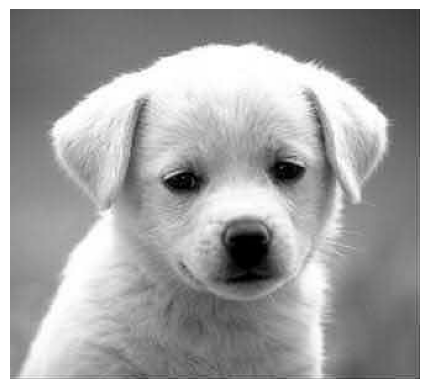


 Original image:



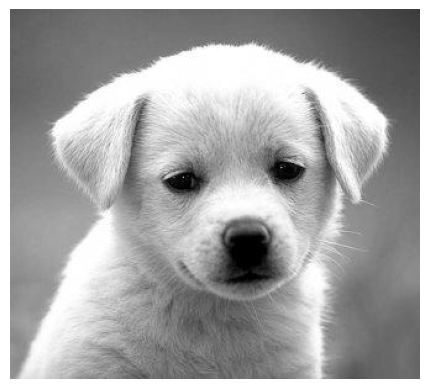


 Image after low compression:



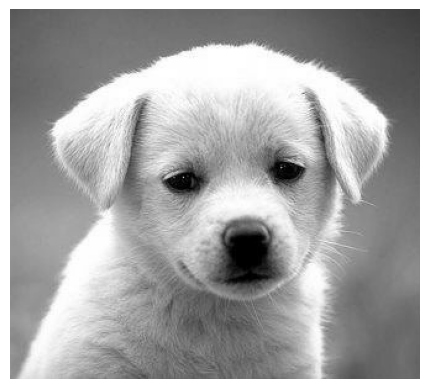

In [295]:
combined_image_H = Image.fromarray(combined_image_array_H) #turn the array to image
print("Image after high compression:\n")
# Display the Highly compressed image
plt.imshow(combined_image_H, cmap='gray')  # cmap='gray' to view a grayscale image
plt.axis('off')  # Turn off axis numbering
plt.show()

print("\n Original image:\n")
# Display the original image
plt.imshow(img_gray, cmap='gray')  # cmap='gray' to view a grayscale image
plt.axis('off')  # Turn off axis numbering
plt.show()

combined_image_L = Image.fromarray(combined_image_array_L) #turn the array to image

print("\n Image after low compression:\n")
# Display the lowly compressed image
plt.imshow(combined_image_L, cmap='gray')  # cmap='gray' to view a grayscale image
plt.axis('off')  # Turn off axis numbering
plt.show()



In [296]:
save_path_L = '/content/drive/MyDrive/UNI/Low_B2DBy.jpg'
combined_image_L= combined_image_L.convert('RGB')
# Save the image
combined_image_L.save(save_path_L)

In [297]:
save_path_H = '/content/drive/MyDrive/UNI/High_B2DBy.jpg'
combined_image_H= combined_image_H.convert('RGB')
# Save the image
combined_image_H.save(save_path_H)

In [298]:
s_H = os.path.getsize(save_path_H)
print ("Size after high compression:",s_H)
s_L = os.path.getsize(save_path_L)
print ("Size after low compression:",s_L)
s = os.path.getsize(save_path)
print ("Size of original image:",s)


Size after high compression: 9335
Size after low compression: 14409
Size of original image: 26225


In [299]:
# Calculate the PSNR (image quality)
OG_IMG = cv2.imread(save_path) # get original image
LC_IMG = cv2.imread(save_path_L) # get low compression image
HC_IMG = cv2.imread(save_path_H) # get high compression image
psnr_L = cv2.PSNR(OG_IMG, LC_IMG) #calculate psnr of the low compression img wrt original immage
psnr_H = cv2.PSNR(OG_IMG, HC_IMG) #calculate psnr of the high compression img wrt original immage
print ("PCNR of low compression:",psnr_L)
print ("PCNR of high compression:",psnr_H)


PCNR of low compression: 49.12614517702116
PCNR of high compression: 31.21872338287442


In [300]:
# calculate compression ratio (CR = size of compressed img / size of original img)
CR_L = s_L / s # compression ratio of low compression
CR_H = s_H / s # compression ratio of high compression
print("Compression ratio when using low quantization:", CR_L)
print("Compression ratio when using high quantization:", CR_H)

Compression ratio when using low quantization: 0.549437559580553
Compression ratio when using high quantization: 0.3559580552907531


In [301]:
def finiteArithmeticEncoder(stream, precision):
  low = 0
  high = 2**precision  #Precision is NO of bits used to represent
  c = 0
  prob = Counter(stream)
  for symbol, prob in prob.items():
    x = 0

values = d.values()
min_ = min(values)
max_ = max(values)

normalized_d = {key: ((v - min_ ) / (max_ - min_) )  for (key, v) in d.iteritems() }


def finiteArithmeticEncoder(stream, precision):
  low = 0
  high = 1
  freq_symbols = Counter(stream)
  prob_symbols = {k: v/len(stream) for k,v in freq_symbols.items()}
  s_ranges = assignRanges(stream)

def assignRanges(prob_symbols):
  #Assign ranges
  ranges = {}
  count_forRanges = 0
  for (symbol, prob) in prob_symbols.items():
    ranges[symbol] = (count_forRanges, count_forRanges + prob)
    count_forRanges += prob
  return ranges

def symbol_FAE(ranges, s, low, high):
  symbol_range = ranges[s].value()
  return







NameError: ignored

In [ ]:
ranges = {}
count_forRanges = 0
symbol = "s1"
#for symbol, prob in prob.items():
ranges[symbol] = (3, 10)
ranges["s2"] = (5, 30)

In [ ]:
ranges

In [ ]:
prob_symbols

In [ ]:
stream = ["s4", "s3", "s2", "s3", "s2", "s2","s1","s1","s1","s1","s1","s1","s0","s0","s0","s0","s0","s0","s0","s0" ]
freq_symbols = Counter(stream)

prob_symbols = {k: v/len(stream) for k,v in freq_symbols.items()}
#define ranges
ranges = {}
count_forRanges = 0
for (symbol, prob) in prob_symbols.items():
  ranges[symbol] = (count_forRanges, count_forRanges + prob)
  count_forRanges += prob
ranges

In [ ]:
high = 1 << 10
high

In [ ]:
FADEncoded_low = []
FADEncoded_high = []
for RLC_l in RLC_Low:
  FADEncoded_low.append(finiteArithmeticEncoder(RLC_l,5))

In [ ]:
freq_symbols = Counter(RLC_Low[0])  # Reuse the frequency calculation from the encoding step
prob_symbols = {k: v / len(RLC_Low) for k, v in freq_symbols.items()}

In [ ]:
FADDecoded_low = []
FADDecoded_high = []
i = 0
for FAD_LOW,RLC_l in zip(FADEncoded_low, RLC_Low):

  freq_symbols = Counter(RLC_l)
  prob_symbols = {k: v / len(RLC_l) for k, v in freq_symbols.items()}
  hello = finiteArithmeticDecoder(FAD_LOW,8,5,prob_symbols)

  if (hello[-1] == 0.0):
    hello.append(1)

  FADDecoded_low.append(hello)
  i = i + 1

In [ ]:
FADDecoded_low[4]

In [ ]:
HuffDecoded_low[3]

In [ ]:
FADDecoded_low[4]

In [ ]:
len(HuffDecoded_low[3])

In [ ]:
Run_Length_Decoder(FADDecoded_low[4])

In [ ]:
RLDC_FAD = []
i = 0
for HD_L in FADDecoded_low:
  RLDC_FAD.append(Run_Length_Decoder(HD_L))

In [ ]:
# Flatten the list of arrays into a single list of values
flattened_list = [value for array in RLDC_FAD for value in np.ravel(array)]


In [ ]:
# Iterate over the flattened_list in chunks of 64
Reversed = []
for i in range(0, len(flattened_list), 64):
    chunk = flattened_list[i:i+64]
    Reversed.append(Reverse_Zigzag_Scan(chunk))  # Call your function with the chunk

In [ ]:
Reversed[342]

In [ ]:
LowDequant = []
i = 0
for LDQ in Reversed:
  i += 1
  if(i == 342):
    break
  LowDequant.append(Dequantize(LDQ , "L"))

In [ ]:
LowDequant_np = np.array(LowDequant)

In [ ]:
IdctBlocksLow = []
for block in LowDequant_np:
  IdctBlocksLow.append(idct_2d(block.reshape(8, 8)))

In [ ]:
combined_image_array = combine_blocks_into_image(IdctBlocksLow,image_shape)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Assuming 'combined_image_array' is the NumPy array obtained after combining the blocks
combined_image = Image.fromarray(combined_image_array)

# Display the image using matplotlib
plt.imshow(combined_image, cmap='gray')  # Use cmap='gray' if it's a grayscale image
plt.axis('off')  # To turn off axis numbering
plt.show()